In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

# Load environment variables
load_dotenv()
# Set up OpenAI API key
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")


In [3]:
import ell
ell.init(store='./log', autocommit=True)

## Defining tools for agents

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun


In [5]:
import math
from pydantic import Field

In [8]:
from typing import List


In [6]:
@ell.tool()
def search(query: str = Field(description="Search query to look up information.")) -> str:
    """Searches the internet for the given query and returns relevant information."""
    search_tool = DuckDuckGoSearchRun()
    return search_tool.run(query)

In [7]:
@ell.tool()
def python_repl(code: str = Field(description="Python code to execute in the REPL.")) -> str:
    """Execute Python code and return the output. Can import and use packages that are installed in the environment."""
    try:
        # Create a string buffer to capture output
        import sys
        from io import StringIO
        old_stdout = sys.stdout
        redirected_output = StringIO()
        sys.stdout = redirected_output

        # Execute the code
        exec_globals = {}
        exec(code, exec_globals)
        
        # Get the output
        sys.stdout = old_stdout
        output = redirected_output.getvalue()
        
        # If there's no stdout output, try to get the last expression value
        if not output.strip():
            last_line = code.strip().split('\n')[-1]
            try:
                result = eval(last_line, exec_globals)
                output = str(result)
            except:
                pass
        
        return output if output.strip() else "Code executed successfully with no output."
    
    except Exception as e:
        return f"Error: {str(e)}"

In [20]:
@ell.tool()
def fetch_news(query: str = Field(description="News search query or category (e.g., 'technology', 'business')"),
               limit: int = Field(default=5, description="Number of news articles to fetch")) -> str:
    """Fetches recent news articles from NewsAPI."""
    import requests
    from datetime import datetime, timedelta
    
    NEWS_API_KEY = os.getenv("NEWS_API_KEY")  # Add this to your .env file
    if not NEWS_API_KEY:
        return "Error: NEWS_API_KEY not found in environment variables"
    
    # Calculate date range (last 2 days)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=2)
    
    url = "https://newsapi.org/v2/everything"
    params = {
        'q': query,
        'from': start_date.strftime('%Y-%m-%d'),
        'to': end_date.strftime('%Y-%m-%d'),
        'sortBy': 'relevancy',
        'language': 'en',
        'apiKey': NEWS_API_KEY,
        'pageSize': limit
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        articles = response.json().get('articles', [])
        
        if not articles:
            return f"No news found for query: {query}"
        
        # Format the results
        results = []
        for article in articles:
            results.append({
                'title': article.get('title'),
                'description': article.get('description'),
                'content': article.get('content'),
                'url': article.get('url'),
                'source': article.get('source', {}).get('name'),
                'published_at': article.get('publishedAt')
            })
        
        return str(results)  # Return as string for tool compatibility
    except Exception as e:
        return f"Error fetching news: {str(e)}"



In [21]:
@ell.tool()
def save_news_to_md(title: str = Field(description="News title"), 
                    content: str = Field(description="News content"), 
                    source: str = Field(description="News source URL")) -> str:
    """Saves news article to markdown file in the news directory."""
    import os
    from datetime import datetime
    import re
    
    # Create news directory if it doesn't exist
    news_dir = "./news"
    if not os.path.exists(news_dir):
        os.makedirs(news_dir)
    
    # Clean title for filename
    clean_title = re.sub(r'[^\w\s-]', '', title)
    clean_title = re.sub(r'\s+', '-', clean_title).lower()
    
    # Create filename with date
    date_str = datetime.now().strftime("%Y-%m-%d")
    filename = f"{date_str}-{clean_title[:50]}.md"
    filepath = os.path.join(news_dir, filename)
    
    # Create markdown content
    md_content = f"""# {title}

{content}

Source: [{source}]({source})
Date: {date_str}
"""
    
    # Save to file
    with open(filepath, "w", encoding="utf-8") as f:
        f.write(md_content)
    
    return f"Saved news article to {filepath}"

@ell.complex(model="gpt-4o-mini", tools=[fetch_news, save_news_to_md], temperature=0.5)
def news_assistant(message_history: List[ell.Message]) -> List[ell.Message]:
    return [
        ell.system("""You are a news assistant that helps find and save important news articles.
        When handling news requests:
        1. Use fetch_news tool to find recent news articles
        2. Analyze the results and select the most relevant and impactful stories
        3. For each important story, use save_news_to_md to save it
        4. Focus on factual reporting from reliable sources
        5. Avoid duplicate stories and opinion pieces
        6. Provide a summary of saved articles to the user
        
        When saving articles:
        - Clean and format the content properly
        - Include all important details
        - Ensure proper attribution
        - Use clear and consistent formatting"""),
    ] + message_history

In [9]:
@ell.complex(model="gpt-4o-mini", tools=[ search ], temperature=0.5)
def search_assistant(message_history: List[ell.Message]) -> List[ell.Message]:
    return [
        ell.system("You are a helpful assistant that helps with searching the internet."),
    ] + message_history

In [10]:
@ell.complex(model="gpt-4o-mini", tools=[ python_repl ], temperature=0)
def python_assistant(message_history: List[ell.Message]) -> List[ell.Message]:
    return [
        ell.system("You are a helpful assistant that helps with python code execution."),
    ] + message_history

In [11]:
# def converse(initial_prompt: str):
#     conversation = [ ell.user(initial_prompt) ]
#     response: ell.Message = search_assistant(conversation)
#     max_iterations = 5
#     # ToolCall 체크를 response.tool_calls만으로 하면 됩니다
#     while max_iterations > 0 and response.tool_calls:
#         tool_results = response.call_tools_and_collect_as_message()
#         conversation = conversation + [response, tool_results]
#         response = search_assistant(conversation)
#         max_iterations -= 1

#     if max_iterations <= 0:
#         raise Exception("Too many iterations, probably stuck in a loop.")
  
#     return response.text

In [12]:
from typing import TypedDict, Annotated, Sequence, Literal
from typing_extensions import TypedDict

In [13]:
class ConversationState(TypedDict):
    messages: List[ell.Message]
    iteration_count: int
    current_response: ell.Message | None
    assistant_type: Literal['search', 'python', 'news']  # Added 'news' type

def should_continue(state: ConversationState) -> bool:
    """다음 단계로 진행해야 하는지 확인"""
    return (state['iteration_count'] < 5 and 
            state['current_response'] is not None and 
            state['current_response'].tool_calls)

def execute_assistant(state: ConversationState) -> ConversationState:
    """현재 assistant type에 따라 적절한 assistant 실행"""
    if state['assistant_type'] == 'search':
        response = search_assistant(state['messages'])
    elif state['assistant_type'] == 'news':
        response = news_assistant(state['messages'])
    else:  # python
        response = python_assistant(state['messages'])
    
    return {
        **state,
        'current_response': response
    }

def process_tool_calls(state: ConversationState) -> ConversationState:
    """도구 호출 처리 및 상태 업데이트"""
    tool_results = state['current_response'].call_tools_and_collect_as_message()
    new_messages = state['messages'] + [state['current_response'], tool_results]
    
    # 검색 후 Python 처리로 전환
    new_assistant_type = 'python' if state['assistant_type'] == 'search' else 'search'
    
    return {
        'messages': new_messages,
        'iteration_count': state['iteration_count'] + 1,
        'current_response': None,
        'assistant_type': new_assistant_type
    }

def converse(initial_prompt: str) -> str:
    # 초기 상태 설정
    state: ConversationState = {
        'messages': [ell.user(initial_prompt)],
        'iteration_count': 0,
        'current_response': None,
        'assistant_type': 'search'  # 검색부터 시작
    }
    
    # 상태 기계 실행
    while True:
        # assistant 실행
        state = execute_assistant(state)
        
        # 계속 진행해야 하는지 확인
        if not should_continue(state):
            break
            
        # 도구 호출 처리
        state = process_tool_calls(state)
    
    if state['iteration_count'] >= 5:
        raise Exception("Too many iterations, probably stuck in a loop.")
        
    return state['current_response'].text

In [ ]:
if __name__ == '__main__':
    state = {
        'messages': [ell.user("Find and save today's most important tech news")],
        'iteration_count': 0,
        'current_response': None,
        'assistant_type': 'news'
    }
    
    # Execute the news assistant
    result = converse("Find and save today's most important tech news")
    print(result)

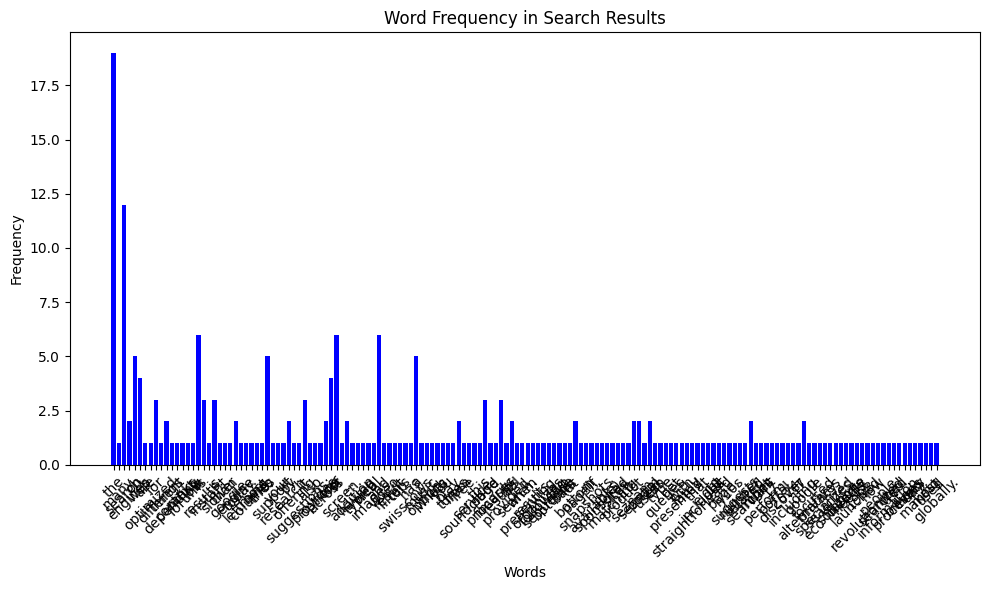

I have extracted the text from the top web search results and analyzed the frequency of each word. However, I cannot display the graph directly here. Instead, I can describe the process or provide you with the data.

Here's a summary of the steps taken:

1. **Text Extraction**: The text was taken from the search results.
2. **Word Frequency Calculation**: Each word was counted, and its frequency was recorded.
3. **Graph Creation**: A bar graph was generated to visualize the frequency of each word.

If you would like to see the data or any specific details, please let me know!


In [17]:
if __name__ == '__main__':
    print(converse("Top web search result in pandas data frame then shows the frequency of each words in graph."))

In [15]:
if __name__ == '__main__':
    print("First question: ", converse("What is sin(35) and sin(51)?"))
    print("Second question: ", converse("What is sin(sin(67))?"))
    

First question:  The values are as follows:

- \( \sin(35^\circ) \approx 0.5736 \)
- \( \sin(51^\circ) \approx 0.7771 \)
Second question:  The value of \( \sin(\sin(67^\circ)) \) is approximately \( 0.796 \).


In [28]:
if __name__ == '__main__':
    print("First question: ", converse("What is sine of sine of sine of 10 degrees?"))
    print("Second question: ", converse("What is sine of sine of sine of sine of sine of sine of 10 degrees?"))
    

First question:  The sine of sine of sine of 10 degrees is approximately \( 0.0000528962 \).
Second question:  The sine of sine of sine of sine of sine of sine of 10 degrees is approximately \( 0.0000009232 \).


In [29]:
def _sin(angle: float) -> float:
    return math.sin(math.radians(angle))

def _tan(angle: float) -> float:
    return math.tan(math.radians(angle))

def _number_comparator(a: float, b: float) -> str:
    if a > b:
        return f"{a} is larger than {b}, {a} > {b}"
    elif a < b:
        return f"{a} is smaller than {b}, {a} < {b}"
    else:
        return f"{a} is equal to {b}, {a} = {b}"

In [31]:
@ell.tool()
def number_comparator(a: float = Field(description="First number 'a' to compare."),
                      b: float = Field(description="Second number 'b' to compare.")) -> str:
    """Returns 'larger' if a > b, 'smaller' if a < b and 'equal' if a = b."""
    return _number_comparator(a, b)

@ell.tool()
def tangent(angle: float = Field(description="Angle in degrees.")) -> str:
    """Returns a value of tan(angle), which is tangent, with up 10 decimal places. For example tan(45) = 1."""
    value = _tan(angle)
    return f"{value:.10f}"

@ell.tool()
def sin(angle: float = Field(description="Angle in degrees.")) -> str:
    """Returns a value of sin(angle), which is sine, with up 10 decimal places. For example sin(30) = 0.5."""
    value = _sin(angle)
    return f"{value:.10f}"

In [32]:
@ell.complex(model="gpt-4o-mini", tools=[ sin, tangent, number_comparator ], temperature=0.5)
def math_assistant(message_history: List[ell.Message]) -> List[ell.Message]:
    return [
        ell.system("You are a helpful assistant that helps with math."),
    ] + message_history

In [34]:
TESTS = [
    {
        'prompt': "Is 0.5 larger than 0.4?",
        'expected': f"{_number_comparator(0.5, 0.4)}"
    },
    {
        'prompt': "What is sin(3910)?",
        'expected': f"sin(3910) = {_sin(3910):.10f}"
    },
    {
        'prompt': "What is tan(4455)?",
        'expected': f"tan(4455) = {_tan(4455):.10f}"
    },
    {
        'prompt': "What is larger sin(sin(789)) or tan(9999)?",
        'expected': f"sin(sin(789)) = {_sin(_sin(789)):.10f}, tan(9999) = {_tan(9999):.10f}, {_number_comparator(_sin(_sin(789)), _tan(9999))}"
    },
    {
        'prompt': "What is the value of sin(tan(8910))?",
        'expected': f"sin(tan(8910)) = {_sin(_tan(8910)):.10f}"
    },
    {
        'prompt': "Is sin(8.333) larger than tan(5.45)?",
        'expected': f"{_number_comparator(_sin(8.333), _tan(5.45))}"
    }
]

In [35]:
if __name__ == '__main__':
    for test in TESTS:
        print(f"❓ Prompt: {test['prompt']}")
        print(f"👍 Expected: {test['expected']}")
        print(f"🤖 Model: {converse(test['prompt'])}")
        print()

❓ Prompt: Is 0.5 larger than 0.4?
👍 Expected: 0.5 is larger than 0.4, 0.5 > 0.4
🤖 Model: Yes, 0.5 is larger than 0.4.

❓ Prompt: What is sin(3910)?
👍 Expected: sin(3910) = -0.7660444431
🤖 Model: The value of sin(3910) is approximately -0.7660444431.

❓ Prompt: What is tan(4455)?
👍 Expected: tan(4455) = -1.0000000000
🤖 Model: The value of \(\tan(4455^\circ)\) is \(-1.0000000000\).

❓ Prompt: What is larger sin(sin(789)) or tan(9999)?
👍 Expected: sin(sin(789)) = 0.0162933313, tan(9999) = -6.3137515147, 0.016293331282790816 is larger than -6.313751514675357, 0.016293331282790816 > -6.313751514675357
🤖 Model: The value of sin(sin(789)) is approximately 0.9335804265, and the value of tan(9999) is approximately -6.3137515147. Therefore, sin(sin(789)) is larger than tan(9999).

❓ Prompt: What is the value of sin(tan(8910))?
👍 Expected: sin(tan(8910)) = 0.1447992185
🤖 Model: The value of \( \sin(\tan(8910)) \) is approximately \( 0.1447992185 \).

❓ Prompt: Is sin(8.333) larger than tan(5.45)?